In [472]:
# imports
import numpy as np
import torch
import torch.nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

# Part 1

In this part, we are going to make a very simple example of a GAN.

The input will be a 1D function as described [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/
).


First, we make the function

In [473]:
def real_function(x):
    f0 = 2.0
    return np.sin(f0 * np.pi * x)


Then we sample it, and plot it

Define the model(s):

A simple fully connected model with 1 hidden layer

The task is to do binary classification; yes or no, whether the sample was real.

In [474]:
def noop(args):
    return args


class SimpleModel(torch.nn.Module):
    def __init__(self, n_input, n_output, n_hidden, output_activation=noop):
        super().__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hidden = n_hidden
        self.hidden_layer = torch.nn.Linear(in_features=self.n_input,
                                            out_features=self.n_hidden)
        self.output_layer = torch.nn.Linear(in_features=self.n_hidden,
                                            out_features=self.n_output)

        self.output_activation = output_activation

        # Init with He (as we use ReLU activation)
        # TODO: really use He and not Xavier
        torch.nn.init.kaiming_uniform_(self.hidden_layer.weight)
        torch.nn.init.kaiming_uniform_(self.output_layer.weight)

    def forward(self, X):
        X = self.hidden_layer(X)
        X = F.relu(X)
        X = self.output_layer(X)
        X = self.output_activation(X)
        return X


class GAN(torch.nn.Sequential):
    def __init__(self, g, d, *args):
        super().__init__(*args)
        self.add_module("generator", g)
        self.add_module("discriminator", d)



Setup data generators

In [475]:
# generate n real samples with class labels
def generate_real_samples(n):
    # generate inputs in [-0.5, 0.5]
    x1 = np.random.rand(n) - 0.5
    # generate outputs X^2
    x2 = real_function(x1)
    # stack arrays
    x1 = x1.reshape(n, 1)
    x2 = x2.reshape(n, 1)
    x = np.hstack((x1, x2)).astype(float)
    # generate class labels
    y = np.ones((n, 1), dtype=float)
    return torch.from_numpy(x).float(), torch.from_numpy(y).float()


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)

    return torch.from_numpy(x_input).float()


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n).float()
    # predict outputs
    x = g.forward(x_input).float()
    # create class labels
    y = np.zeros((n, 1), dtype=float)
    y = torch.from_numpy(y).float()
    return x, y


def summarize_performance(epoch, g, d, latent_dim, n=100):
    # prepare real and fake samples
    x_real, y_real = generate_real_samples(n)
    x_fake, y_fake = generate_fake_samples(g, latent_dim, n)
    # evaluate discriminator on fake examples
    with torch.no_grad():
        y_mreal = d.forward(x_real).reshape(-1)
        y_mfake = d.forward(x_fake).reshape(-1)
    acc_real = 0.0
    acc_fake = 0.0
    for f, r, mf, mr in zip(y_fake, y_real, y_mfake, y_mreal):
        acc_real += 1 if r > .5 and mr > .5 or r < .5 and mr < .5 else 0
        acc_fake += 1 if f > .5 and mf > .5 or f < .5 and mf < .5 else 0
    acc_real /= len(y_fake)
    acc_fake /= len(y_fake)

    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    # scatter plot real and fake data points
    plt.figure()
    plt.scatter(x_real[:, 0].detach().numpy(), x_real[:, 1].detach().numpy(), color='red')
    plt.scatter(x_fake[:, 0].detach().numpy(), x_fake[:, 1].detach().numpy(), color='blue')
    plt.scatter(x_real[y_mreal[:]>.5, 0].detach().numpy(), x_real[y_mreal[:]>.5, 1].detach().numpy(), color='green')
    plt.scatter(x_fake[y_mfake<.5, 0].detach().numpy(), x_fake[y_mfake<.5, 1].detach().numpy(), color='yellow')
    plt.legend(['real', 'fake', 'hits_real', 'hits_fake'])
    plt.show()


Train the GAN

In [476]:
n_data_per_epoch = 1000
batchsize = 128
n_epochs = 100
n_batches = n_data_per_epoch // batchsize


def train_batch(X, y, model, optimizer, loss_function=torch.nn.BCELoss):
    optimizer.zero_grad()
    X_model = model(X)
    loss = loss_function()(X_model, y)
    loss.backward()
    optimizer.step()

    return model, optimizer, loss

def train(generator, discriminator, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters())
    optimizer_generator = torch.optim.Adam(generator.parameters())
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        # train discriminator
        discriminator, optimizer_discriminator, loss_real = train_batch(x_real,
                                                                        y_real,
                                                                        discriminator,
                                                                        optimizer_discriminator)
        discriminator, optimizer_discriminator, loss_fake = train_batch(x_fake,
                                                                        y_fake,
                                                                        discriminator,
                                                                        optimizer_discriminator)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = torch.ones((n_batch, 1)).float()
        # train the generator via the discriminator's error
        gan_model, optimizer_generator, loss = train_batch(x_gan,
                                                           y_gan,
                                                           gan_model,
                                                           optimizer_generator)
        # evaluate the model every n_eval epochs
        if (i + 1) % n_eval == 0:
            summarize_performance(i, generator, discriminator, latent_dim)

Setup experiment and run

4999 0.15 0.96


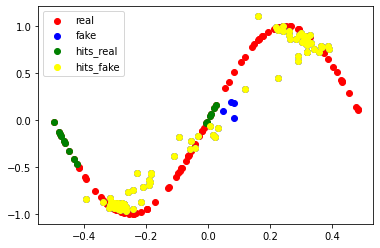

9999 0.64 0.23


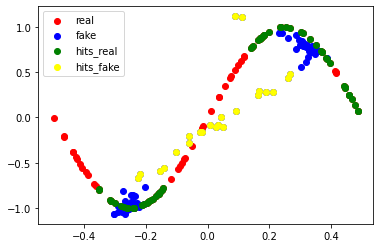

14999 0.42 0.65


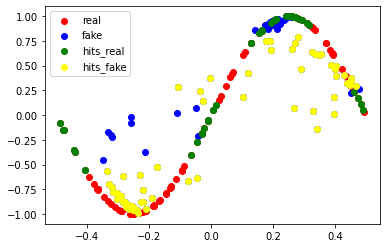

19999 0.61 0.52


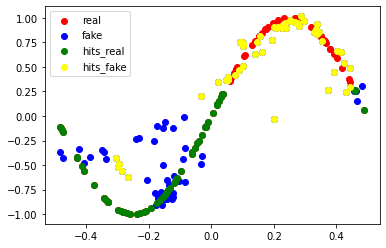

24999 0.63 0.63


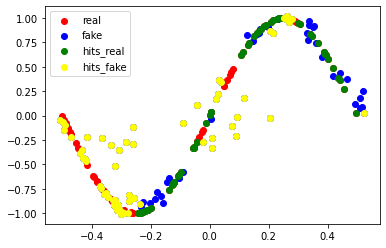

29999 0.69 0.52


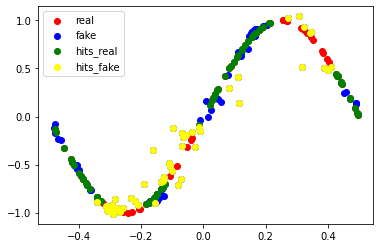

34999 0.64 0.39


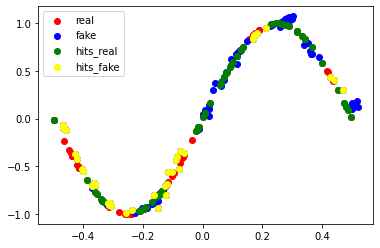

39999 0.49 0.66


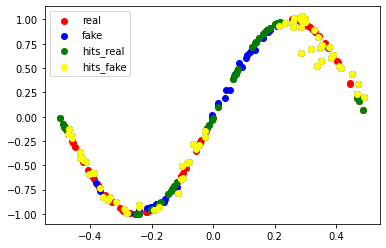

44999 0.5 0.47


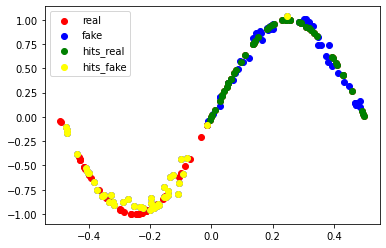

49999 0.49 0.51


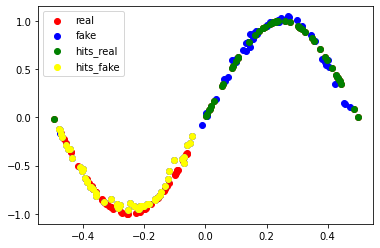

In [479]:

n_function = 2
n_latent_variables = 5

discriminator = SimpleModel(n_input=n_function,
                            n_output=1, # Fixed real/fake output
                            n_hidden=25,
                            output_activation=torch.nn.Sigmoid())

generator = SimpleModel(n_input=n_latent_variables,
                        n_output=n_function,
                        n_hidden=50,
                        output_activation=noop)

gan_model = GAN(generator, discriminator)

train(generator=generator,
      discriminator=discriminator,
      gan_model=gan_model,
      latent_dim=n_latent_variables,
      n_epochs=50000,
      n_eval=5000,
      n_batch=128)

In [478]:
print('done')

done
